In [2]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf
from torchvision import transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import os
import time
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the FeatureExtractor class for EfficientNet-B3
class FeatureExtractor:
    def __init__(self):
        """
        Initialize the FeatureExtractor with EfficientNet-B3 as the backbone.
        The model is loaded with pre-trained weights, and the fully connected (FC) layer is removed 
        to use the network as a feature extractor.
        """
        # Load EfficientNet-B3 pre-trained on ImageNet
        self.model = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        # Remove the classifier (FC layer) to get feature embeddings
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])
        self.model.eval()  # Set the model to evaluation mode

        # Define the transformation pipeline for input preprocessing
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  # Convert numpy arrays to PIL images
            transforms.Resize((300, 300)),  # Resize images to match EfficientNet-B3 input size
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # Normalization values for ImageNet-trained models
                std=[0.229, 0.224, 0.225]   # Standard deviation values for normalization
            ),
        ])

    def extract(self, images):
        """
        Extract feature vectors for a batch of input images.
        
        Args:
            images (numpy.ndarray): Batch of raw images as numpy arrays.
        
        Returns:
            numpy.ndarray: Array of feature vectors extracted from the images.
        """
        features = []  # Initialize a list to store feature vectors
        with torch.no_grad():  # Disable gradient calculations to save memory and computation
            for img in images:
                # Apply transformations to preprocess the image
                img_transformed = self.transform(img)
                img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension (1, C, H, W)
                # Pass the image through the model to extract features
                feature = self.model(img_transformed).squeeze().numpy()
                features.append(feature)  # Store the extracted feature vector

        return np.array(features)  # Return all features as a numpy array

# Define paths to the dataset directories
train_data_dir = '/content/drive/MyDrive/part_one_dataset/train_data'
eval_data_dir = '/content/drive/MyDrive/part_one_dataset/eval_data'

# Instantiate the FeatureExtractor class
extractor = FeatureExtractor()

# Define a function to process datasets and extract features
def process_datasets(data_dir, prefix, num_datasets, output_dir):
    """
    Process datasets by extracting feature vectors using EfficientNet-B3 and saving them as .npy files.
    
    Args:
        data_dir (str): Path to the directory containing dataset files.
        prefix (str): Prefix for dataset files (e.g., 'train', 'eval').
        num_datasets (int): Number of dataset files to process.
        output_dir (str): Path to the directory where features will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for i in range(1, num_datasets + 1):  # Iterate through the datasets
        data_path = os.path.join(data_dir, f"{i}_{prefix}_data.tar.pth")  # Construct dataset file path
        dataset = torch.load(data_path)  # Load the dataset file
        images = dataset['data']  # Replace 'data' with the actual key for images in your dataset

        print(f"Processing {prefix} dataset {i}...")  # Log the processing status
        # Extract features using the FeatureExtractor
        features = extractor.extract(images)
        # Define the path to save extracted features
        output_path = os.path.join(output_dir, f"{i}_{prefix}_features.npy")
        np.save(output_path, features)  # Save features as a .npy file
        print(f"Saved features for {prefix} dataset {i} to {output_path}")  # Log the save status

# Define output directories for training and evaluation features
train_output_dir = '/content/drive/MyDrive/part_one_dataset/eb3_extracted_features/train'
eval_output_dir = '/content/drive/MyDrive/part_one_dataset/eb3_extracted_features/eval'

# Process and extract features from training and evaluation datasets
process_datasets(train_data_dir, 'train', 10, train_output_dir)
process_datasets(eval_data_dir, 'eval', 10, eval_output_dir)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.7MB/s]
<ipython-input-9-3a3d2605a3c9>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loade

Processing train dataset 1...
Saved features for train dataset 1 to /content/drive/MyDrive/part_one_dataset/extracted_features/train/1_train_features.npy
Processing train dataset 2...
Saved features for train dataset 2 to /content/drive/MyDrive/part_one_dataset/extracted_features/train/2_train_features.npy
Processing train dataset 3...
Saved features for train dataset 3 to /content/drive/MyDrive/part_one_dataset/extracted_features/train/3_train_features.npy
Processing train dataset 4...
Saved features for train dataset 4 to /content/drive/MyDrive/part_one_dataset/extracted_features/train/4_train_features.npy
Processing train dataset 5...
Saved features for train dataset 5 to /content/drive/MyDrive/part_one_dataset/extracted_features/train/5_train_features.npy
Processing train dataset 6...
Saved features for train dataset 6 to /content/drive/MyDrive/part_one_dataset/extracted_features/train/6_train_features.npy
Processing train dataset 7...
Saved features for train dataset 7 to /content

In [3]:
class PrototypeClassifier:
    """
    A simple classifier based on class prototypes.
    Each class is represented by a prototype, which is the average of all feature vectors assigned to that class.
    Classifies new data based on the closest prototype using Euclidean distance.
    """

    def __init__(self):
        """
        Initialize the classifier with empty dictionaries for:
        - `prototypes`: Stores the feature vector representing each class.
        - `class_counts`: Tracks the number of data points assigned to each class.
        """
        self.prototypes = {}  # Maps class labels to their prototype feature vectors
        self.class_counts = {}  # Maps class labels to the count of samples assigned to each class

    def euclidean_distance(self, x, y):
        """
        Calculate the Euclidean distance between two vectors.

        Args:
            x (numpy.ndarray): The first vector.
            y (numpy.ndarray): The second vector.

        Returns:
            float: The Euclidean distance between `x` and `y`.
        """
        return np.linalg.norm(x - y)

    def train(self, features, labels):
        """
        Train the classifier by computing prototypes for each class.
        Each prototype is the mean feature vector for its respective class.

        Args:
            features (numpy.ndarray): Feature vectors for training data.
            labels (numpy.ndarray): Corresponding labels for the training data.
        """
        for feature, label in zip(features, labels):
            if label not in self.prototypes:
                # If the class is encountered for the first time, initialize its prototype and count
                self.prototypes[label] = feature
                self.class_counts[label] = 1
            else:
                # Update the prototype by calculating the running mean
                self.prototypes[label] = (
                    self.prototypes[label] * self.class_counts[label] + feature
                ) / (self.class_counts[label] + 1)
                # Increment the count of samples for this class
                self.class_counts[label] += 1

    def predict(self, features):
        """
        Predict the class labels for a given set of feature vectors.
        Classification is based on the closest prototype in terms of Euclidean distance.

        Args:
            features (numpy.ndarray): Feature vectors for prediction.

        Returns:
            numpy.ndarray: Predicted class labels for each feature vector.
        """
        predictions = []  # List to store predicted labels
        for feature in features:
            # Compute distances from the feature to all class prototypes
            distances = {
                label: self.euclidean_distance(feature, prototype)
                for label, prototype in self.prototypes.items()
            }
            # Predict the label of the closest prototype
            predictions.append(min(distances, key=distances.get))
        return np.array(predictions)

    def update_classifier(self, features, pseudo_labels):
        """
        Incrementally update the classifier with new data and pseudo-labels.
        This is useful for semi-supervised or active learning scenarios.

        Args:
            features (numpy.ndarray): New feature vectors.
            pseudo_labels (numpy.ndarray): Pseudo-labels for the new data.
        """
        for feature, pseudo_label in zip(features, pseudo_labels):
            if pseudo_label not in self.prototypes:
                # If the class is new, initialize its prototype and count
                self.prototypes[pseudo_label] = feature
                self.class_counts[pseudo_label] = 1
            else:
                # Update the prototype by calculating the running mean
                self.prototypes[pseudo_label] = (
                    self.prototypes[pseudo_label] * self.class_counts[pseudo_label] + feature
                ) / (self.class_counts[pseudo_label] + 1)
                # Increment the count of samples for this pseudo-label
                self.class_counts[pseudo_label] += 1


In [4]:
def save_model(model, path):
    """
    Save a Python object (e.g., a trained model) to a file using pickle.

    Args:
        model (object): The Python object to save.
        path (str): Path to save the file.
    """
    with open(path, 'wb') as f:
        pickle.dump(model, f)


def load_model(path):
    """
    Load a Python object (e.g., a trained model) from a pickle file.

    Args:
        path (str): Path to the pickle file.

    Returns:
        object: The loaded Python object.
    """
    with open(path, 'rb') as f:
        return pickle.load(f)


def task1_train_features():
    """
    Train a prototype-based classifier incrementally on pre-extracted feature datasets (D1 to D10).
    - Each dataset contains features and corresponding labels.
    - The first dataset is used to initialize the classifier.
    - Subsequent datasets are used to update the classifier incrementally.
    - Each trained model is saved to Google Drive after processing a dataset.

    Logs the time taken for each training step.
    """
    classifier = None  # Initialize the classifier as None

    # Directory containing feature datasets
    feature_dir = "/content/drive/MyDrive/part_one_dataset/eb3_extracted_features/train"
    timings = []  # List to store the time taken for each training step

    # Loop through datasets D1 to D10
    for i in range(1, 11):
        start_time = time.time()  # Start timer for the training step

        # Paths to the feature and label files for the current dataset
        feature_path = os.path.join(feature_dir, f"{i}_train_features.npy")
        label_path = os.path.join(feature_dir, f"{i}_train_labels.npy")

        # Load the feature vectors (Numpy format)
        features = np.load(feature_path)
        # Load the labels (PyTorch format, stored in a tar.pth file for Dataset D1)
        if i == 1:
            labels = torch.load('/content/drive/MyDrive/part_one_dataset/train_data/1_train_data.tar.pth')['targets']
        else:
            labels = np.load(label_path)

        print(f"Loaded dataset {i} - Features shape: {features.shape}, Labels shape: {labels.shape}")

        if i == 1:
            # Initialize and train the classifier with the first dataset
            classifier = PrototypeClassifier()
            classifier.train(features, labels)
        else:
            # Use pseudo-labels if labels are not provided; otherwise, use true labels
            if labels is None:
                pseudo_labels = classifier.predict(features)
                print(f"Dataset {i} does not have labels. Using pseudo-labels.")
            else:
                pseudo_labels = labels

            # Incrementally update the classifier with the new data
            classifier.update_classifier(features, pseudo_labels)

        # Save the trained classifier to Google Drive
        save_path = f"/content/drive/MyDrive/eb3_trained_models/f{i}_features.pkl"
        save_model(classifier, save_path)
        print(f"Trained and saved model f{i}_features.pkl to Google Drive at {save_path}")

        # Stop timer and calculate elapsed time
        end_time = time.time()
        elapsed_time = end_time - start_time
        timings.append((i, elapsed_time))
        print(f"Time taken to train model f{i}: {elapsed_time:.2f} seconds")

    # Log total timings for all datasets
    print("\n--- Training Summary ---")
    for i, time_taken in timings:
        print(f"Dataset {i}: {time_taken:.2f} seconds")


In [5]:
task1_train_features()

<ipython-input-4-a9156c8bd7cd>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load('/content/drive/MyDrive/part_one_dataset/train_data/1_train_data.tar.pth

Loaded dataset 1 - Features shape: (2500, 1536), Labels shape: (2500,)
Trained and saved model f1_features.pkl to Google Drive at /content/drive/MyDrive/eb3_trained_models/f1_features.pkl
Time taken to train model f1: 3.15 seconds
Loaded dataset 2 - Features shape: (2500, 1536), Labels shape: (2500,)
Trained and saved model f2_features.pkl to Google Drive at /content/drive/MyDrive/eb3_trained_models/f2_features.pkl
Time taken to train model f2: 1.78 seconds
Loaded dataset 3 - Features shape: (2500, 1536), Labels shape: (2500,)
Trained and saved model f3_features.pkl to Google Drive at /content/drive/MyDrive/eb3_trained_models/f3_features.pkl
Time taken to train model f3: 2.26 seconds
Loaded dataset 4 - Features shape: (2500, 1536), Labels shape: (2500,)
Trained and saved model f4_features.pkl to Google Drive at /content/drive/MyDrive/eb3_trained_models/f4_features.pkl
Time taken to train model f4: 1.91 seconds
Loaded dataset 5 - Features shape: (2500, 1536), Labels shape: (2500,)
Train

In [12]:
def task1_test_features():
    """
    Evaluate saved classifiers (f1 to f10) on corresponding test datasets (D1 to D10).
    - Each model is tested on its corresponding datasets up to the training iteration (e.g., f5 is tested on D1 to D5).
    - Accuracy results are recorded in a matrix.
    - Log time taken for each testing step.
    - Plot the accuracy matrix as a heatmap.

    Returns:
        None
    """
    # Directory containing the pre-extracted feature datasets for evaluation
    feature_dir = "/content/drive/MyDrive/part_one_dataset/eb3_extracted_features/eval"
    timings = []  # List to store time taken for each model's evaluation
    accuracy_matrix = np.zeros((10, 10))  # Initialize a 10x10 accuracy matrix

    # Loop through models f1 to f10
    for i in range(1, 11):
        start_time = time.time()  # Start timer for the testing step

        # Load the saved classifier for model f{i}
        model_path = f"/content/drive/MyDrive/eb3_trained_models/f{i}_features.pkl"
        classifier = load_model(model_path)

        # Loop through datasets D1 to D{i} for evaluation
        for j in range(1, i + 1):
            # Path to the pre-extracted features for dataset D{j}
            feature_path = os.path.join(feature_dir, f"{j}_eval_features.npy")

            # Load the test features and labels for the dataset
            features = np.load(feature_path)
            labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.pth')['targets']

            # Predict labels using the trained classifier
            predictions = classifier.predict(features)

            # Calculate accuracy for the dataset and store it in the matrix
            accuracy = accuracy_score(labels, predictions) * 100
            accuracy_matrix[i - 1, j - 1] = accuracy
            print(f"Model f{i}, Dataset D{j} - Accuracy: {accuracy:.2f}%")

        # End timer and calculate elapsed time
        end_time = time.time()
        elapsed_time = end_time - start_time
        timings.append((i, elapsed_time))
        print(f"Time taken to test model f{i}: {elapsed_time:.2f} seconds")

    # Plotting the accuracy matrix as a heatmap
    plt.figure(figsize=(10, 8))  # Set figure size for better readability
    sns.heatmap(
        accuracy_matrix,
        annot=True,  # Annotate each cell with its accuracy value
        fmt=".2f",  # Format to two decimal places
        cmap="viridis",  # Use a visually appealing color map
        xticklabels=[f"D{j}" for j in range(1, 11)],  # Label x-axis with datasets
        yticklabels=[f"f{i}" for i in range(1, 11)],  # Label y-axis with models
    )
    plt.title("Accuracy Matrix for Test Data")  # Add a title to the plot
    plt.xlabel("Dataset")  # Label the x-axis
    plt.ylabel("Model")  # Label the y-axis
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

    # Optionally return results (commented for now)
    # return accuracy_matrix, timings


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f1, Dataset D1 - Accuracy: 87.92%
Time taken to test model f1: 2.71 seconds


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f2, Dataset D1 - Accuracy: 88.08%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f2, Dataset D2 - Accuracy: 89.60%
Time taken to test model f2: 2.99 seconds


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f3, Dataset D1 - Accuracy: 87.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f3, Dataset D2 - Accuracy: 89.08%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f3, Dataset D3 - Accuracy: 89.12%
Time taken to test model f3: 3.10 seconds


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f4, Dataset D1 - Accuracy: 87.80%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f4, Dataset D2 - Accuracy: 89.20%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f4, Dataset D3 - Accuracy: 88.64%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f4, Dataset D4 - Accuracy: 89.04%
Time taken to test model f4: 4.77 seconds


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f5, Dataset D1 - Accuracy: 86.80%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f5, Dataset D2 - Accuracy: 88.68%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f5, Dataset D3 - Accuracy: 87.92%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f5, Dataset D4 - Accuracy: 88.16%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f5, Dataset D5 - Accuracy: 87.48%
Time taken to test model f5: 4.09 seconds


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f6, Dataset D1 - Accuracy: 86.04%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f6, Dataset D2 - Accuracy: 88.28%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f6, Dataset D3 - Accuracy: 87.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f6, Dataset D4 - Accuracy: 87.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f6, Dataset D5 - Accuracy: 86.76%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f6, Dataset D6 - Accuracy: 87.80%
Time taken to test model f6: 4.02 seconds


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f7, Dataset D1 - Accuracy: 86.36%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f7, Dataset D2 - Accuracy: 87.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f7, Dataset D3 - Accuracy: 87.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f7, Dataset D4 - Accuracy: 87.64%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f7, Dataset D5 - Accuracy: 87.00%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f7, Dataset D6 - Accuracy: 87.92%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f7, Dataset D7 - Accuracy: 86.52%
Time taken to test model f7: 4.45 seconds


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f8, Dataset D1 - Accuracy: 86.40%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f8, Dataset D2 - Accuracy: 87.84%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f8, Dataset D3 - Accuracy: 87.68%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f8, Dataset D4 - Accuracy: 87.84%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f8, Dataset D5 - Accuracy: 86.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f8, Dataset D6 - Accuracy: 87.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f8, Dataset D7 - Accuracy: 86.92%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f8, Dataset D8 - Accuracy: 87.24%
Time taken to test model f8: 5.38 seconds


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f9, Dataset D1 - Accuracy: 85.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f9, Dataset D2 - Accuracy: 87.64%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f9, Dataset D3 - Accuracy: 86.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f9, Dataset D4 - Accuracy: 86.96%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f9, Dataset D5 - Accuracy: 86.00%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f9, Dataset D6 - Accuracy: 87.12%
Model f9, Dataset D7 - Accuracy: 86.16%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f9, Dataset D8 - Accuracy: 87.04%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f9, Dataset D9 - Accuracy: 85.64%
Time taken to test model f9: 5.54 seconds


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D1 - Accuracy: 85.40%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D2 - Accuracy: 87.40%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D3 - Accuracy: 86.88%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D4 - Accuracy: 86.48%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D5 - Accuracy: 85.92%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D6 - Accuracy: 87.04%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D7 - Accuracy: 86.04%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D8 - Accuracy: 86.68%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D9 - Accuracy: 85.48%


<ipython-input-12-254dafa7e500>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f10, Dataset D10 - Accuracy: 85.96%
Time taken to test model f10: 4.91 seconds


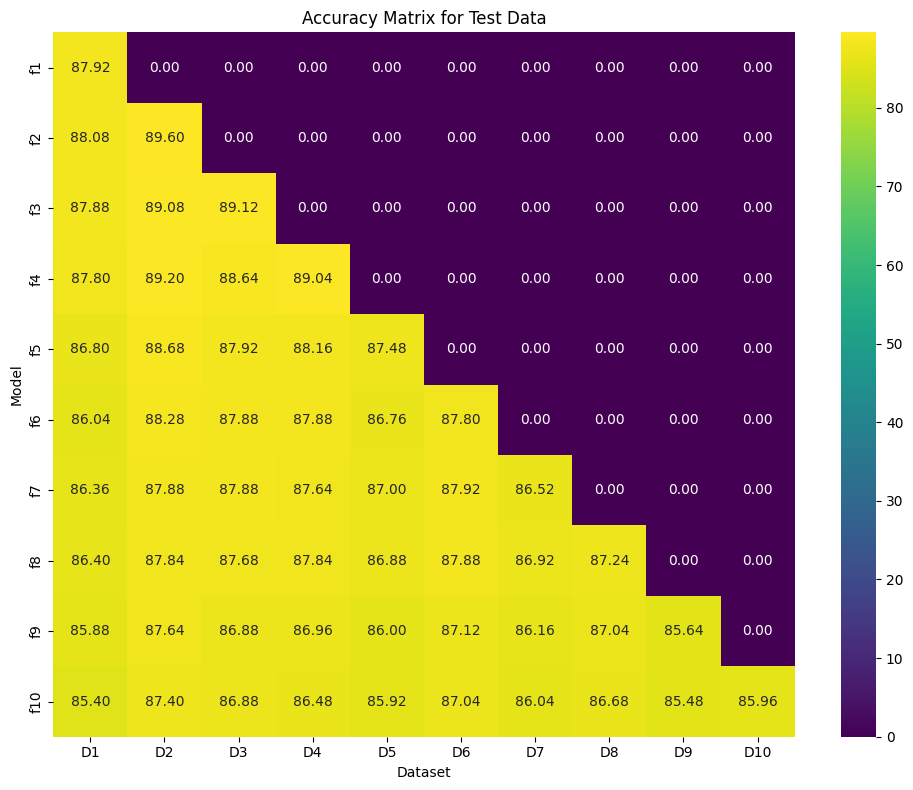

In [13]:
task1_test_features()